In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
df = pd.read_csv('./data/Affairs.csv')

df.drop('Unnamed: 0', axis = 1, inplace = True)
df.affairs = (df.affairs > 0).replace({False: 0, True: 1})

df.head()

,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
0,0,male,37.0,10.00,no,3,18,7,4
1,0,female,27.0,4.00,no,4,14,6,4
2,0,female,32.0,15.00,yes,1,12,1,4
3,0,male,57.0,15.00,yes,5,18,6,5
4,0,male,22.0,0.75,no,2,17,6,3


In [3]:
np.unique(df.affairs)

array([0, 1], dtype=int64)

In [4]:
df.affairs.value_counts()

0    451
1    150
Name: affairs, dtype: int64

In [5]:
df.gender.value_counts()

female    315
male      286
Name: gender, dtype: int64

In [6]:
df.isna().sum()

affairs          0
gender           0
age              0
yearsmarried     0
children         0
religiousness    0
education        0
occupation       0
rating           0
dtype: int64

In [7]:
cat_df = df.copy()
# encoding affair as binary categorical variable to look for differences in groupings
cat_df.affairs = (cat_df.affairs > 0).replace({True: 1, False: 0})
cat_df.gender.replace({'female': 0, 'male': 1}, inplace = True)
cat_df.children.replace({'no': 0, 'yes': 1}, inplace = True)

group = cat_df.groupby('affairs').mean()
group

,gender,age,yearsmarried,children,religiousness,education,occupation,rating
affairs,,,,,,,,
0,0.461197,32.18071,7.727279,0.68071,3.203991,16.139690,4.155211,4.093126
1,0.520000,33.41000,9.531947,0.82000,2.853333,16.246667,4.313333,3.446667


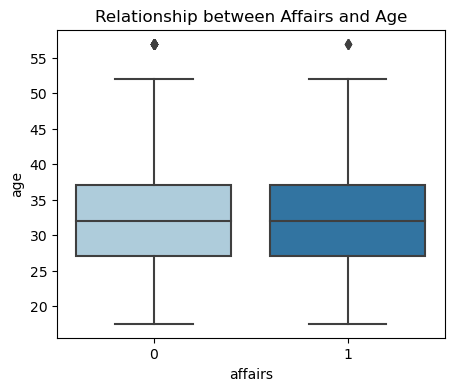

In [8]:
plt.figure(figsize = (5,4))

plt.title("Relationship between Affairs and Age")
sns.boxplot(x = df.affairs, y = df.age, palette = 'Paired')

plt.show()

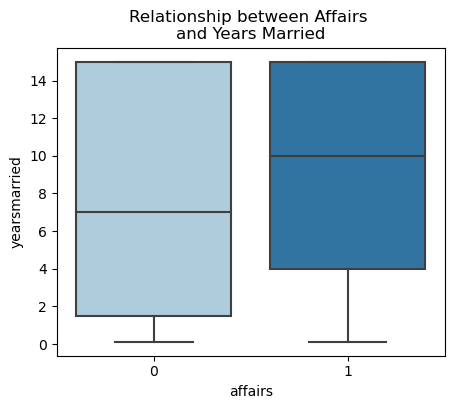

In [9]:
# do people who have been married longer, cheat more?

plt.figure(figsize = (5,4))

plt.title("Relationship between Affairs \nand Years Married")
sns.boxplot(x = df.affairs, y = df.yearsmarried, palette = 'Paired')

plt.show()

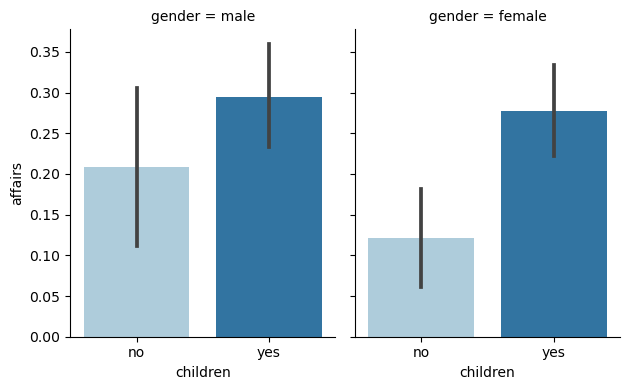

In [10]:
# who's more likely to cheat, men with kids or women with kids?
sns.catplot(data = df, x = 'children', y = 'affairs', col = 'gender',
            kind = 'bar', palette = 'Paired', height = 4, aspect = .8)

plt.show()

# It appears that people with children cheat more often

In [11]:
# are couple with children happier in their marriage than couples without children?

new_group = df.groupby('children').mean()
new_group

,affairs,age,yearsmarried,religiousness,education,occupation,rating
children,,,,,,,
no,0.157895,26.277778,3.120871,2.877193,16.192982,4.461988,4.274854
yes,0.286047,34.956977,10.188665,3.211628,16.155814,4.088372,3.795349


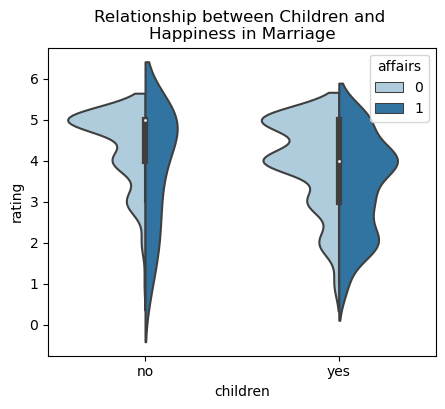

In [12]:
plt.figure(figsize = (5,4))

sns.violinplot(data = df, x = 'children', y = 'rating', hue = 'affairs', split = True, palette = 'Paired')
plt.title("Relationship between Children and \nHappiness in Marriage")

plt.show()

# couples who have kids seem to be less happy in their marriages

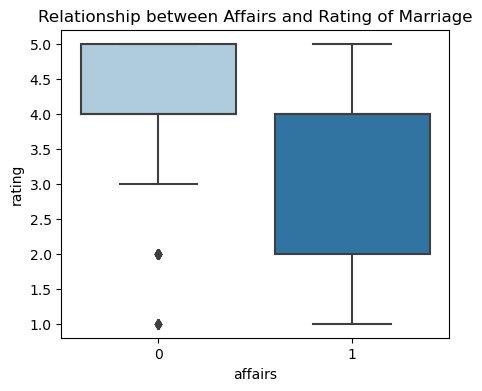

In [13]:
plt.figure(figsize = (5,4))

plt.title("Relationship between Affairs and Rating of Marriage")
sns.boxplot(x = df.affairs, y = df.rating, palette = 'Paired')

plt.show()

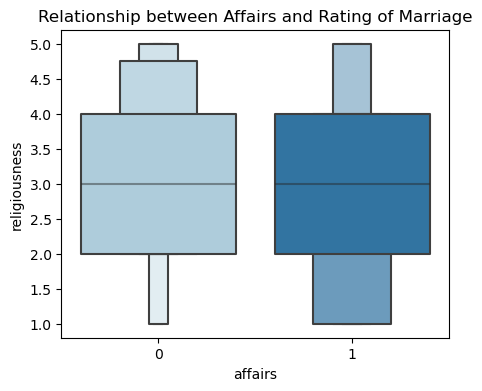

In [14]:
plt.figure(figsize = (5,4))

plt.title("Relationship between Affairs and Rating of Marriage")
sns.boxenplot(x = df.affairs, y = df.religiousness, palette = 'Paired')

plt.show()

### Testing for Statistical Significant to decide parameters

In [15]:
def perm_fun(df, col, len_a):
    a = df.sample(n = len_a, replace = False)
    b = df[~df.index.isin(a.index)]
    
    return a[col].mean() - b[col].mean()

In [16]:
def generate_diffs_and_graph(col, len_a):
    # generated permuted differences
    actual_diff = group.loc[1][col] - group.loc[0][col]
    diffs = [perm_fun(cat_df, col, len_a) for _ in range(1000)]
    
    # plot permuted differences and actual difference
    plt.figure(figsize = (5,4))
    sns.histplot(diffs)
    plt.axvline(x = actual_diff, color = 'red')
    plt.title(f"Perm Test (statistical significance) for {col}")
    plt.show()

    # calculate and print p-val for statistical significance test
    p_val = [np.abs(diff) > np.abs(actual_diff) for diff in diffs]
    p_val = np.array(p_val).mean()
    print("p-val:", p_val)
    
    return p_val

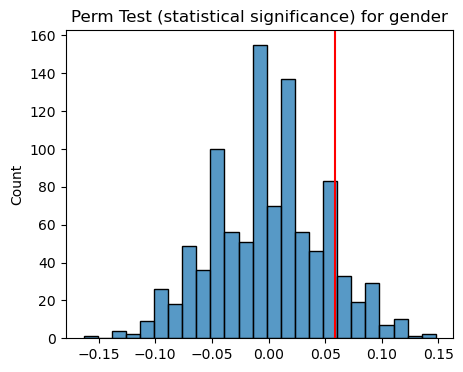

p-val: 0.21


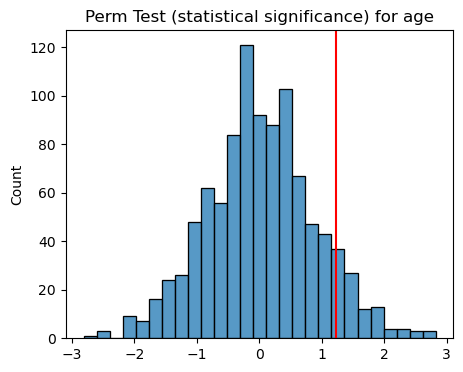

p-val: 0.155


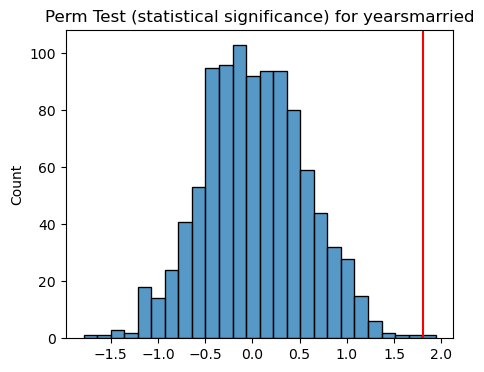

p-val: 0.001


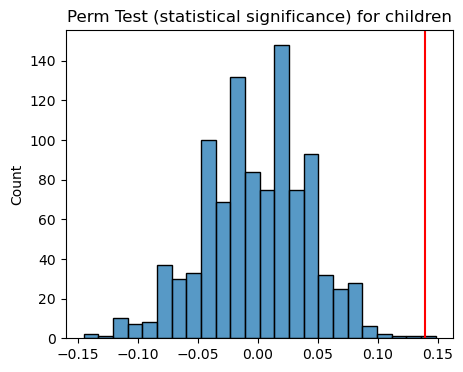

p-val: 0.002


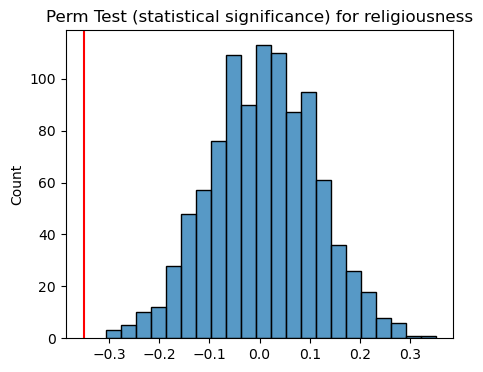

p-val: 0.001


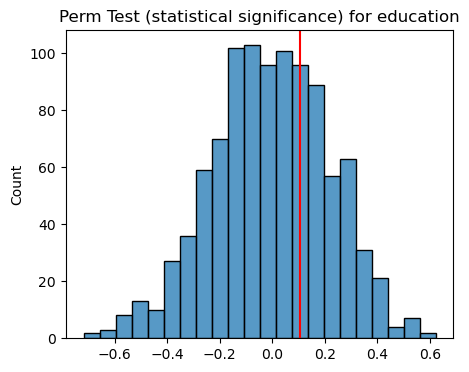

p-val: 0.646


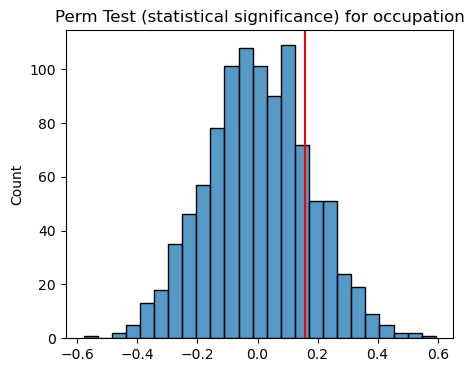

p-val: 0.357


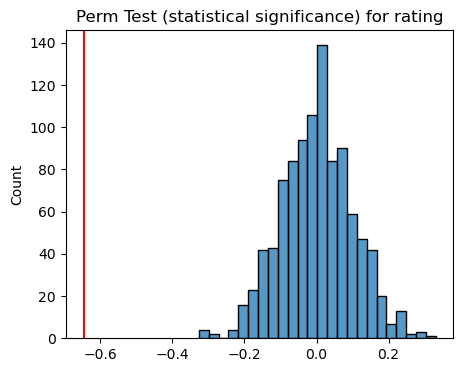

p-val: 0.0


In [17]:
significant_vars = []
len_a = df.affairs.value_counts().loc[1]

for col in group.columns:
    p_val = generate_diffs_and_graph(col, len_a)
    if (p_val <= .05):
        significant_vars.append(col)

In [18]:
significant_vars

['yearsmarried', 'children', 'religiousness', 'rating']

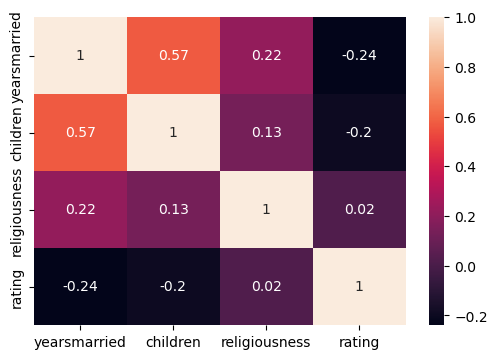

In [19]:
# looking for multi-collinearity in potential predictor vars

plt.figure(figsize = (6,4))
sns.heatmap(cat_df[significant_vars].corr().round(2), annot = True)
plt.show()

In [20]:
significant_vars.remove('children')
significant_vars

['yearsmarried', 'religiousness', 'rating']

# Modeling

In [21]:
cat_df

,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
0,0,1,37.0,10.00,0,3,18,7,4
1,0,0,27.0,4.00,0,4,14,6,4
2,0,0,32.0,15.00,1,1,12,1,4
3,0,1,57.0,15.00,1,5,18,6,5
4,0,1,22.0,0.75,0,2,17,6,3
...,...,...,...,...,...,...,...,...,...
596,1,1,22.0,1.50,1,1,12,2,5
597,1,0,32.0,10.00,1,2,18,5,4
598,1,1,32.0,10.00,1,2,17,6,5
599,1,1,22.0,7.00,1,3,18,6,2


In [22]:
X = cat_df[significant_vars]
y = cat_df.affairs

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7)

clf = LogisticRegression(random_state = 0)
clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [23]:
df_test = pd.merge(X_test, y_test, left_index = True, right_index = True)
df_test['ClfPred'] = clf.predict(df_test[significant_vars])

In [24]:
print("Accuracy Metrics for Logistic Regression")
print(f"   accuracy score: {np.round(accuracy_score(df_test.affairs, df_test.ClfPred), 3) * 100}%")
print(f"   precision score: {np.round(precision_score(df_test.affairs, df_test.ClfPred), 3) * 100}%")
print(f"   recall score: {np.round(recall_score(df_test.affairs, df_test.ClfPred), 3) * 100}%")

Accuracy Metrics for Logistic Regression
   accuracy score: 77.3%
   precision score: 41.699999999999996%
   recall score: 12.8%


In [25]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [26]:
df_test['RfPred'] = rf.predict(df_test[significant_vars])

In [27]:
print("Accuracy Metrics for Random Forest")
print(f"   accuracy score: {np.round(accuracy_score(df_test.affairs, df_test.RfPred), 3) * 100}%")
print(f"   precision score: {np.round(precision_score(df_test.affairs, df_test.RfPred), 3) * 100}%")
print(f"   recall score: {np.round(recall_score(df_test.affairs, df_test.RfPred), 3) * 100}%")

Accuracy Metrics for Random Forest
   accuracy score: 68.5%
   precision score: 27.500000000000004%
   recall score: 28.199999999999996%


## Grid Search CV for best hyperparameters

In [28]:
params = [{
    "n_estimators": [100,200,300],
    "max_depth": [3,5,7,9],
    "min_samples_split": [5,10,20],
    "criterion": ['gini', 'entropy']
}]

In [29]:
rf = RandomForestClassifier()
rf_gridsearch = GridSearchCV(rf, param_grid = params)

rf_gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 5, 7, 9],
                          'min_samples_split': [5, 10, 20],
                          'n_estimators': [100, 200, 300]}])

In [30]:
best_params = rf_gridsearch.best_params_
best_params

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 10,
 'n_estimators': 300}

In [32]:
rf = RandomForestClassifier(n_estimators = best_params['n_estimators'], criterion = best_params['criterion'], 
                            max_depth = best_params['max_depth'], min_samples_split = best_params['min_samples_split'])
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=300)

In [33]:
df_test['RfPred'] = rf.predict(df_test[significant_vars])

print("Accuracy Metrics for Random Forest w/Grid Search CV to find best Hyperparameters")
print(f"   accuracy score: {np.round(accuracy_score(df_test.affairs, df_test.RfPred), 3) * 100}%")
print(f"   precision score: {np.round(precision_score(df_test.affairs, df_test.RfPred), 3) * 100}%")
print(f"   recall score: {np.round(recall_score(df_test.affairs, df_test.RfPred), 3) * 100}%")

Accuracy Metrics for Random Forest w/Grid Search CV to find best Hyperparameters
   accuracy score: 76.2%
   precision score: 35.699999999999996%
   recall score: 12.8%
